# Trajectory inference for hematopoiesis in mouse using simulated federated PCA

This code has been adapted from a scanpy vignette: Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

In [2]:
#sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
#results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  
sc.settings.figdir='/home/anne/Documents/featurecloud/pca/horizontal-pca/figures/single-cell'# low dpi (dots per inch) yields small inline figures

In [3]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [4]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

Let us work with a higher precision than the default 'float32' to ensure _exactly_ the same results across different computational platforms.

In [5]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

## Preprocessing and Visualization

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [6]:
sc.pp.recipe_zheng17(adata)

In [7]:
sc.tl.pca(adata, svd_solver='arpack')

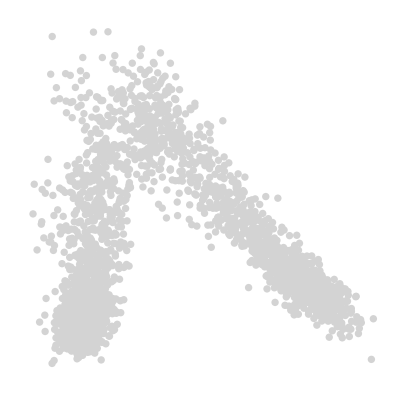

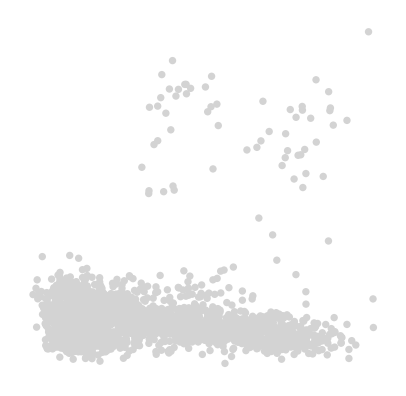

In [8]:
sc.pl.pca(adata, components =['1,2'], save='paga_12_centralised')
sc.pl.pca(adata, components =['2,3'], save='paga_23_centralised')

In [9]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/anne/Documents/featurecloud/pca/federated_dp_pca')
from python.PCA.horizontal.horizontal_pca_benchmark import wrapper_k_variation
import python.PCA.shared_functions as sh
import os.path as op
import os
import seaborn
import python.PCA.horizontal.horizontal_pca_power_iteration as h
import python.PCA.horizontal.balcan as b
#import python.PCA.horizontal.bai as bai
import python.PCA.horizontal.proxy_covariance as proxy
import python.PCA.vertical.simulate_federated_vertically_partionned_pca as vertical
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.linalg as la

import python.PCA.comparison as co

In [10]:
data_list, r = sh.partition_data_horizontally(adata.X, splits=5, equal=True, randomize=False)
# simulate federated approximate PCA
k = 50
xx, ee = b.simulate_federated_horizontal_pca(data_list, k)
proj = np.dot(adata.X, xx)


(100, 1000)
(100, 1000)
(100, 1000)
(100, 1000)
(100, 1000)
Intermediate dimensions100
(500, 1000)


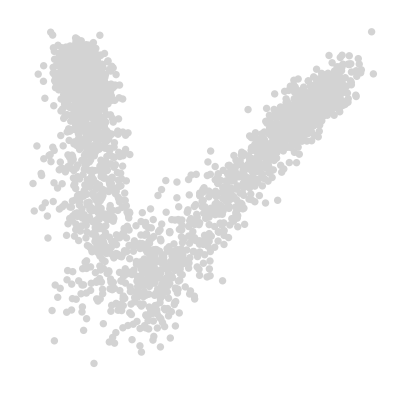

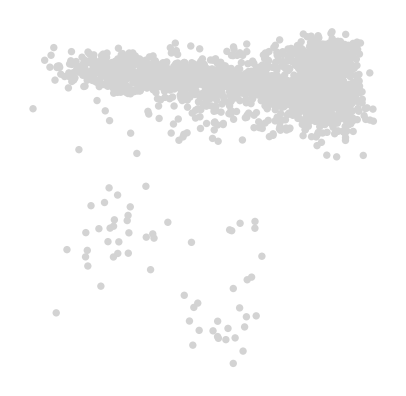

In [11]:
adata.obsm['X_pca'] = proj
adata.varm['PCs'] = xx
sc.pl.pca(adata,  components =['1,2'], save='approx_paga_12')
sc.pl.pca(adata, components =['2,3'], save='paga_23')

In [12]:
# angles = co.compute_angles(adata.varm['PCs_approx'], adata.varm['PCs'])[0:10]
# angles = [np.round(a, 2) for a in angles]
# pd.DataFrame(angles).to_csv('/home/anne/Documents/featurecloud/pca/horizontal-pca/results/single-cell/paga_angles_cent_approx.tsv', sep='\t')

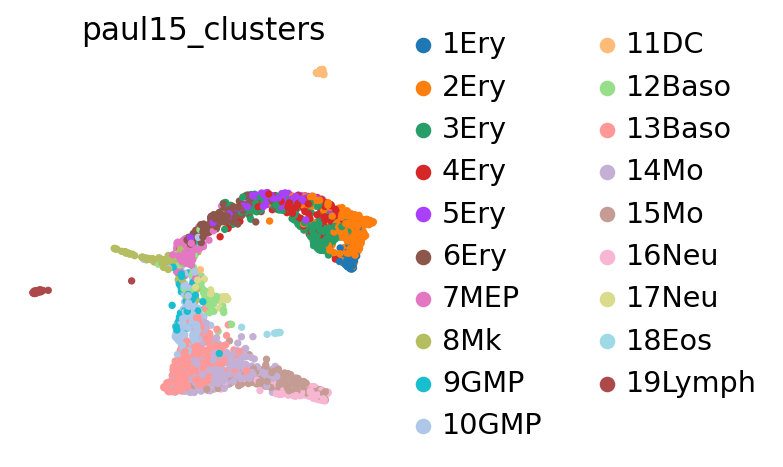

In [13]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='paul15_clusters', save='graph_approx')

## Optional: Denoising the graph

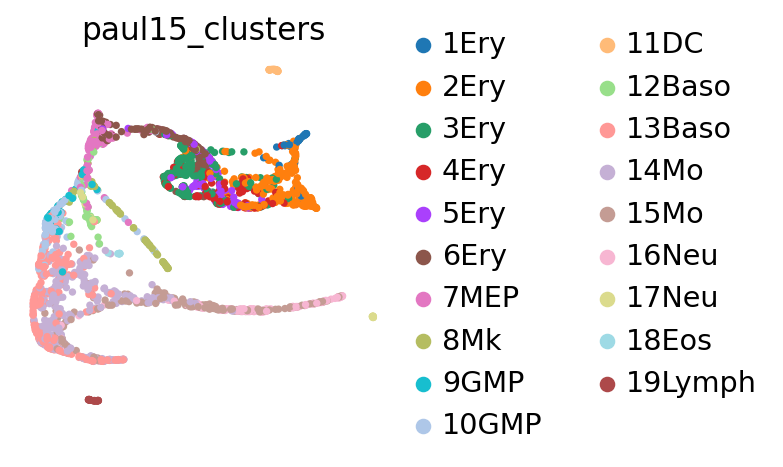

In [14]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='paul15_clusters',save='graph_approx_denoised')

This still looks messy, but in a different way: a lot of the branches are overplotted.

## Clustering and PAGA

<div class="alert alert-info">

**Note**

Note that today, we'd use `sc.tl.leiden` - here, we use `sc.tl.louvain` the sake of reproducing the paper results.
    
</div>  

In [15]:
sc.tl.leiden(adata, resolution=1.0)

Annotate the clusters using marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|

For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [16]:
sc.tl.paga(adata, groups='leiden')

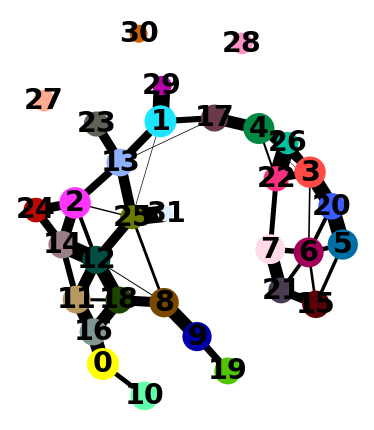

In [17]:
sc.pl.paga(adata, color=['leiden'], save='leiden_approx')